# Application of generalized (hyper-) dual numbers: Peng-Robinson Equation of State

This notebook shows an example for the application of generalized dual numbers for equations of state.
A [simple version](https://en.wikipedia.org/wiki/Equation_of_state#Peng%E2%80%93Robinson_equation_of_state) of the Peng-Robinson equation of state is used for demonstration purposes.

## Contents <a class="anchor" id="toc"></a>

- [Definition of the Equation of State as Python `class`](#python_class)
- [Compute Pressure](#pressure)
- [Fugacity](#fugacity)
- [Critical Points](#critical_point)
    - [Validation](#cp_validation)
    - [$T_c$ of Binary Mixture](#cp_binary)
- [Comparison to Numerical Derivatives](#comparison)
    - [First Derivatives](#1st_derivatives)
    - [Second Derivatives](#2nd_derivatives)
- [Performance](#performance)

In [1]:
# import everything from num_dual, import numpy and define some constants
from num_dual import *
import numpy as np

RGAS = 1.380649e-23 * 6.02214076e23 # Gas constant in units of J/mol/K
SQRT2 = np.sqrt(2)

## Definition of the Equation of State as Python `class` <a class="anchor" id="python_class"></a> 
[↑ back to Contents](#toc)

The following cell implements the Peng-Robinson equation of state as Python `class`.
Inputs are

- critical temperature, $T_c$, in units of Kelvin,
- critical pressure, $p_c$, in units of bar,
- the dimensionless acentric factor, $\omega$, and
- binary parameters for mixtures (optional).

For mixtures, arrays of $T_c$, $p_c$, and $\omega$ have to be provided.

Once an instance of the equation of state is instanciated, the `helmholtz_energy` function can be evaluated for a given temperature, $T$, volume, $V$, and amount of substance, $\mathbf{N}$.
Using the `derivative` function from `num_dual`, inputs can be transformed to the respective dual numbers and partial derivatives can be computed.

In [2]:
class PengRobinson:
    def __init__(self, critical_temperature, critical_pressure, acentric_factor, delta_ij=None):
        """Peng-Robinson Equation of State
        
        Parameters
        ----------
        critical_temperature : np.array[float]
            critical temperature of each component in units of Kelvin.
        critical_pressure : np.array[float]
            critical pressure of each component in units of bar.
        acentric_factor : np.array[float] 
            acentric factor of each component (dimensionless).
        delta_ij : np.array[[float]], optional
            binary parameters. Shape=[n, n], n = number of components.
            defaults to zero for all binary interactions.
            
        Raises
        ------
        ValueError: if the input values have incompatible sizes.
        """
        self.n = len(critical_temperature)
        if len(set((len(critical_temperature), len(critical_pressure), len(acentric_factor)))) != 1:
            raise ValueError("Input parameters must all have the same lenght.")
        
        # for a pure substance, store values as floats
        if isinstance(critical_temperature, np.ndarray) and self.n == 1:
            self.tc = critical_temperature[0]
            self.pc = critical_pressure[0]
            self.omega = acentric_factor[0]
        else:
            self.tc = critical_temperature
            self.pc = critical_pressure
            self.omega = acentric_factor
            
        # [a / R] = m³ / mol / K
        self.a_r = 0.45724 * RGAS * self.tc**2 / (1e5 * self.pc)
        # [b] = m³ / mol
        self.b = 0.0778 * RGAS * self.tc / (1e5 * self.pc)
        self.delta_ij = np.zeros((self.n, self.n)) if delta_ij is None else delta_ij
        self.kappa = 0.37464 + 1.54226 * self.omega - 0.26992 * self.omega**2
    
    def helmholtz_energy(self, temperature, volume, moles):
        """Return helmholtz energy in units of Joule/mol
        
        Parameters
        ----------
        temperature : float | any dual number
            temperature in units of Kelvin.
        volume : float | any dual number
            volume in units of m³.
        moles : np.array(float | any dual number) or List(float | any dual number)
            amount of substance for each component in units of mole.
            
        Returns
        -------
        helmholtz_energy: float | any dual number
            The return type depends on the input types.
            
        Raises
        ------
        ValueError : if the number of substances with which the equation of 
            state was defined is not equal to the size of `moles`.
        """
        # transform scalar values and lists into numpy.ndarrays
        if not isinstance(moles, np.ndarray):
            moles = np.array(moles)
        if moles.size != self.n:
            raise ValueError(f"Equation of state initialized for {self.n} component(s) but moles has length {len(moles)}!")
        
        n = np.sum(moles)
        x = moles / n
        tr = temperature / self.tc
        ak = ((1.0 - np.sqrt(tr)) * self.kappa + 1.0)**2 * self.a_r
        ak_mix = 0.0
        
        # apply combination rule if mixture
        if self.n > 1:
            for i in range(self.n):
                for j in range(self.n):
                    ak_mix += np.sqrt(ak[i] * ak[j]) * (x[i] * x[j] * (1.0 - self.delta_ij[i, j]))
        else:
            ak_mix = ak
            
        b = np.sum(x * self.b)
        v = volume
        a = RGAS * temperature * n * (np.log(v / (v - b * n)) - ak_mix / (b * SQRT2 * 2.0 * temperature) * np.log((v * (SQRT2 - 1.0) + b * n) / (v * (SQRT2 + 1.0) - b * n)))
        return a
    
    def pressure(self, temperature, volume, moles):
        """Analytic implementation of the pressure in units of Pa for the
        Peng-Robinson equation of state. Used as a reference for the comparison
        of different differentiation methods.
        
        Parameters
        ----------
        temperature : float | any dual number
            temperature in units of Kelvin.
        volume : float | any dual number
            volume in units of m³.
        moles : np.array(float | any dual numbe) or List(float | any dual number)
            amount of substance for each component in units of mole.
            
        Returns
        -------
        pressure: float | any dual number
            The return type depends on the input types.
            
        Raises
        ------
        ValueError : if the number of substances with which the equation of 
            state was defined is not equal to the size of `moles`.
        """
        # transform scalar values and lists into numpy.ndarrays
        if not isinstance(moles, np.ndarray):
            moles = np.array(moles)
        if moles.size != self.n:
            raise ValueError(f"Equation of state initialized for {self.n} component(s) but moles has length {len(moles)}!")
        
        n = np.sum(moles)
        x = moles / n
        tr = temperature / self.tc
        ak = ((1.0 - np.sqrt(tr)) * self.kappa + 1.0)**2 * self.a_r
        ak_mix = 0.0
        
        # apply combination rule if mixture
        if self.n > 1:
            for i in range(0, self.n):
                for j in range(0, self.n):
                    ak_mix += np.sqrt(ak[i] * ak[j]) * (x[i] * x[j] * (1.0 - self.delta_ij[i, j]))
        else:
            ak_mix = ak
            
        b = np.sum(x * self.b)
        v = volume
        p = RGAS * (temperature * n / (v - b * n) - ak_mix * n**2 / (v**2 + 2 * b * v * n - (b * n)**2))
        return p
    
    def dp_dv(self, temperature, volume, moles):
        """Analytic implementation of the volume derivative of the pressure in 
        units of Pa/m³ for the Peng-Robinson equation of state. Used as a 
        reference for the comparison of different differentiation methods.
        
        Parameters
        ----------
        temperature : float | any dual number
            temperature in units of Kelvin.
        volume : float | any dual number
            volume in units of m³.
        moles : np.array(float | any dual numbe) or List(float | any dual number)
            amount of substance for each component in units of mole.
            
        Returns
        -------
        dp_dv: float | any dual number
            The return type depends on the input types.
            
        Raises
        ------
        ValueError : if the number of substances with which the equation of 
            state was defined is not equal to the size of `moles`.
        """
        # transform scalar values and lists into numpy.ndarrays
        if not isinstance(moles, np.ndarray):
            moles = np.array(moles)
        if moles.size != self.n:
            raise ValueError(f"Equation of state initialized for {self.n} component(s) but moles has length {len(moles)}!")
        
        n = np.sum(moles)
        x = moles / n
        tr = temperature / self.tc
        ak = ((1.0 - np.sqrt(tr)) * self.kappa + 1.0)**2 * self.a_r
        ak_mix = 0.0
        
        # apply combination rule if mixture
        if self.n > 1:
            for i in range(0, self.n):
                for j in range(0, self.n):
                    ak_mix += np.sqrt(ak[i] * ak[j]) * (x[i] * x[j] * (1.0 - self.delta_ij[i, j]))
        else:
            ak_mix = ak
            
        b = np.sum(x * self.b)
        v = volume
        dp_dv = RGAS * (-temperature * n / (v - b * n)**2 + 2 * ak_mix * n**2 * (v + b * n) / (v**2 + 2 * b * v * n - (b * n)**2)**2)
        return dp_dv

## Compute pressure <a class="anchor" id="pressure"></a>
[↑ back to Contents](#toc)

The equation of state object can be created using one or more components. Here we

- define the equation of state for a single substance,
- define temperature (in Kelvin), volume (in m³) and amount of substance (as array with size 1, in mole),
- compute the pressure via the `pressure` method (which implements the analytical derivative), and
- compute the pressure via dual numbers, using `derive1(v)` to create a `Dual64` for the volume as input to `helmholtz_energy`.

We can then compare the resulting pressures.

In [3]:
# create equation of state
tc = np.array([523.0])
pc = np.array([25.0])
omega = np.array([0.2])

pr = PengRobinson(tc, pc, omega)

# create thermodynamic state
t = 300.0
v = 0.003
n = np.array([1.0])
ideal_gas_pressure = np.sum(n) * RGAS * t / v

# analytical expression for pressure
p_analytical = pr.pressure(t, v, n)
# pressure using Dual64 for the volume
p_dual = -pr.helmholtz_energy(t, derive1(v), n).first_derivative + ideal_gas_pressure

print(f"ideal gas pressure   : {ideal_gas_pressure:8.4f} Pa")
print(f"pressure (analytical): {p_analytical:8.4f} Pa")
print(f"pressure (dual)      : {p_dual:8.4f} Pa")
print(f"relative deviation   : {np.abs(p_analytical - p_dual) / p_analytical:8.4g} %")

ideal gas pressure   : 831446.2618 Pa
pressure (analytical): 392996.7935 Pa
pressure (dual)      : 392996.7935 Pa
relative deviation   : 5.924e-16 %


## Fugacity <a class="anchor" id="fugacity"></a>
[↑ back to Contents](#toc)

The helmholtz energy, entropy and pressure (or chemical potential) can all be computed in a single evaluation.
The return value is then `HyperDual64` and the second (mixed) partial derivatives is evaluated automatically.

In [4]:
# thermodynamic state
t = 300.0
v = 3e-3
n = np.array([1.0])

dt, dv = derive2(t, v)
da_dtdv = pr.helmholtz_energy(dt, dv, n)
print("Return value data type: ", type(da_dtdv))
print(f"A          : {da_dtdv.value*1e-3:8.4f} kJ")
print(f"S          : {-da_dtdv.first_derivative[0]:8.4f} J/K")
print(f"P          : {(-da_dtdv.first_derivative[1] + ideal_gas_pressure)*1e-3:8.4f} kPa")
print(f"∂p/∂T=∂S/∂V: {-da_dtdv.second_derivative*1e-3:8.4f} kPa/K")

Return value data type:  <class 'builtins.HyperDual64'>
A          :  20.1683 kJ
S          :  28.8785 J/K
P          : 392.9968 kPa
∂p/∂T=∂S/∂V:   0.8280 kPa/K


The fugacity coefficient can be computed from derivatives with respect to the amount of substance per component.

In [5]:
p = -pr.helmholtz_energy(t, derive1(v), n).first_derivative + ideal_gas_pressure
z = p * v / (RGAS * t) # compressibility
d2a_dn2 = pr.helmholtz_energy(t, v, derive2(n))
fugacity = d2a_dn2.first_derivative - np.log(z)

print(f"RT ln(φ) : {fugacity:8.4f} J/mol")

RT ln(φ) : 18853.7037 J/mol


## Critical Points <a class="anchor" id="critical_point"></a>
[↑ back to Contents](#toc)

Dual numbers can be used to enhance existing methods for calculating critical points. The exact calculation of higher order derivatives is crucial in the context of critical points, as the third derivatives of the Helmholtz energy appear in the objective function (and not just in any Jacobian). The examples below demonstrate the implementation of the algorithm based on the approach by Heidemann, Khalil and Michelsen.

In [6]:
from scipy.optimize import fsolve
from numpy.linalg import eig
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
sns.set_style("ticks")
sns.set_palette("Dark2")

def critical_point(equation_of_state, initial_temperature, initial_density, moles):
    return fsolve(lambda x: objective_function(equation_of_state, *x, moles), [initial_temperature, initial_density])
    
def objective_function(equation_of_state, temperature, density, moles):
    # transform scalar values and lists into numpy.ndarrays
    if isinstance(moles, (float, int)):
        moles = np.array([moles])
    if not isinstance(moles, np.ndarray):
        moles = np.array(moles)
    if moles.size != equation_of_state.n:
        raise ValueError(f"Equation of state initialized for {equation_of_state.n} component(s) but moles has length {len(moles)}!")

    # calculate the M matrix
    total_moles = sum(moles)
    volume = total_moles / density
    M = np.array(equation_of_state.helmholtz_energy(temperature, volume, derive2(moles)).second_derivative)
    if equation_of_state.n == 1:
        M = np.array([[M]])
    for i in range(equation_of_state.n):
        for j in range(equation_of_state.n):
            M[i,j] *= np.sqrt(moles[i] * moles[j])

    # add the ideal gas contribution
    ig = RGAS * temperature
    for i in range(equation_of_state.n):
        M[i,i] += ig
    
    # calculate the smallest eigenvalue and the corresponding eigenvector
    l, u = eig(M)
    i = np.argmin(l)
    l = l[i]
    u = u[:,i]
    
    # calculate the second criticality condition
    s = derive3(0)
    n = moles + u * s * np.sqrt(moles)
    ig = -RGAS * temperature * sum(u**3/np.sqrt(moles))
    return [l, equation_of_state.helmholtz_energy(temperature, total_moles/density, n).third_derivative + ig]

### Validation: Compare computed critical pressure and temperature with input parameters <a class="anchor" id="cp_validation"></a>
[↑ back to Contents](#toc)

As a validation, we can compute the critical temperature and pressure for a pure substance and compare the results to the substance's parameters, which are the critical properties, $T_c$ and $p_c$.

In [43]:
# create equation of state
tc = np.array([523.0])
pc = np.array([25.0])
omega = np.array([0.2])
pr = PengRobinson(tc, pc, omega)

tc_calc, densityc_calc = critical_point(pr, 450, 2500, [1.0])
pc_calc = pr.pressure(tc_calc, 1.0 / densityc_calc, np.array([1.0]))
print("Comparison between input parameters and critical properties via Heidemann, Kalil and Michelsen method.")
print(f"rel. dev. of critical temperature : {np.abs(tc[0] - tc_calc) / tc[0] * 100:.2g} / %")
print(f"rel. dev. of critical pressure    : {np.abs(pc[0] - pc_calc / 1e5) / pc[0] * 100:.2g} / %")

Comparison between input parameters and critical properties via Heidemann, Kalil and Michelsen method.
rel. dev. of critical temperature : 0.0024 / %
rel. dev. of critical pressure    : 0.0075 / %


### Critical Temperature for Binary Mixture <a class="anchor" id="cp_binary"></a>
[↑ back to Contents](#toc)

Below we compute the critical locus of a binary mixture described by the Peng-Robinson equation of state for 101 mole fractions. The plot shows how the critical temperature of the mixture changes with the mole fraction of component 1.

In [7]:
%%time
tc_mix = np.array([523.0, 420.])
pc_mix = np.array([25.0, 69.0])
omega_mix = np.array([0.2, 0.1])

pr_mix = PengRobinson(tc_mix, pc_mix, omega_mix)

x = np.linspace(1e-5, 1-1e-5, 101)
tc_vec = []
for xi in x:
    tc, _ = critical_point(pr_mix, 450, 2500, [xi, 1-xi])
    tc_vec.append(tc)

CPU times: user 616 ms, sys: 17.2 ms, total: 633 ms
Wall time: 614 ms


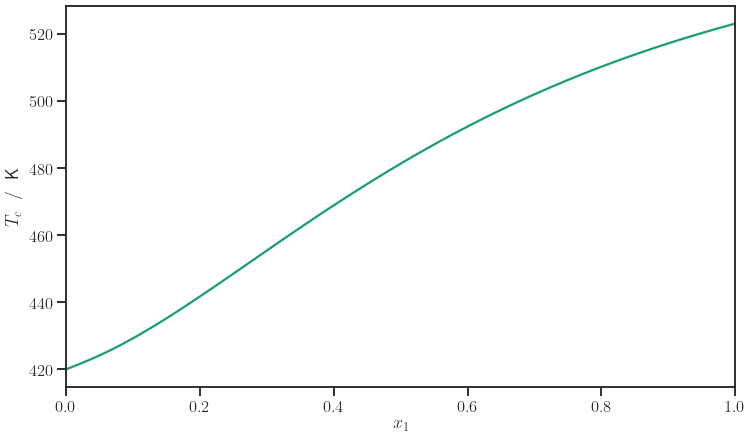

In [8]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(x, tc_vec)
ax.set_xlim(0,1)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$T_c~~/~~$K");

## Comparison to Numerical Derivatives <a class="anchor" id="comparison"></a>
[↑ back to Contents](#toc)

The `derive` function sets the dual part of the argument to 1. Instead of 1 an arbitrary step size could be used without any effect on the result of the calculation. This is in contrast to numerical differentiation where an optimal step size has to be identified for every situation. To demonstrate this, the error in the derivative from dual numbers is calculated for different step sizes and compared to forward differences, central differences, and [complex step differentiation](https://blogs.mathworks.com/cleve/2013/10/14/complex-step-differentiation/), with the analytical expression for the pressure of the Peng-Robinson equation of state as reference.

In [9]:
from functools import partial
import matplotlib.pyplot as plt

def dual_derivative(equation_of_state, t, v, n, h, prop):
    if prop == "temperature":
        f = partial(equation_of_state.helmholtz_energy, volume=v, moles=n)
        arg = t
    elif prop == "volume":
        f = partial(equation_of_state.helmholtz_energy, temperature=t, moles=n)
        arg = v
    elif prop == "moles":
        f = partial(equation_of_state.helmholtz_energy, volume=v, temperature=t)
        arg = n
    
    first_derivative = f(**{prop: Dual64(arg, h)}).first_derivative / h
    second_derivative = f(**{prop: Dual2_64(arg, h, 0)}).second_derivative / h**2
    return first_derivative, second_derivative

def forward_difference(equation_of_state, t, v, n, h, prop):
    if prop == "temperature":
        f = partial(equation_of_state.helmholtz_energy, volume=v, moles=n)
        arg = t
    elif prop == "volume":
        f = partial(equation_of_state.helmholtz_energy, temperature=t, moles=n)
        arg = v
    elif prop == "moles":
        f = partial(equation_of_state.helmholtz_energy, volume=v, temperature=t)
        arg = n
    
    first_derivative = (f(**{prop: arg + h}) - f(**{prop: arg})) / h
    return first_derivative

def central_difference(equation_of_state, t, v, n, h, prop):
    if prop == "temperature":
        f = partial(equation_of_state.helmholtz_energy, volume=v, moles=n)
        arg = t
    elif prop == "volume":
        f = partial(equation_of_state.helmholtz_energy, temperature=t, moles=n)
        arg = v
    elif prop == "moles":
        f = partial(equation_of_state.helmholtz_energy, volume=v, temperature=t)
        arg = n
    
    first_derivative = (f(**{prop: arg + h}) - f(**{prop: arg - h})) / (2*h)
    second_derivative = (f(**{prop: arg + h}) - 2*f(**{prop: arg}) + f(**{prop: arg - h})) / h**2
    return first_derivative, second_derivative

def complex_step(equation_of_state, t, v, n, h, prop):
    if prop == "temperature":
        f = partial(equation_of_state.helmholtz_energy, volume=v, moles=n)
        arg = t
    elif prop == "volume":
        f = partial(equation_of_state.helmholtz_energy, temperature=t, moles=n)
        arg = v
    elif prop == "moles":
        f = partial(equation_of_state.helmholtz_energy, volume=v, temperature=t)
        arg = n
    
    first_derivative = f(**{prop: arg + h*1j}).imag / h
    return first_derivative

### First derivatives <a class="anchor" id="1st_derivatives"></a>
[↑ back to Contents](#toc)

In the example below, for first derivatives, forward and central differences show a minimum error at $h\approx 1e-10$ and $h\approx 1e-7$ respectively. At the optimal value, the errors are significantly larger than machine precision, particularly for forward differences. Complex step differentiation reaches machine precision as long as the step width is below a certain threshold. In opposition to that, automatic differentiation using dual numbers returns the exact values within machine precision for any step size.

In [10]:
def rel_dev(x, ref):
    return np.abs(ref - x) / ref * 100

ref = pr.pressure(t, v, n)

hs = np.logspace(-18, -3, 500)
d_dd = []
d_fd = []
d_cd = []
d_cs = []
for h in hs:
    dd, _ = dual_derivative(pr, t, v, n, h, "volume")
    fd = forward_difference(pr, t, v, n, h, "volume")
    cd, _ = central_difference(pr, t, v, n, h, "volume")
    cs = complex_step(pr, t, v, n ,h, "volume")
    d_dd.append(rel_dev(-dd + ideal_gas_pressure, ref))
    d_fd.append(rel_dev(-fd + ideal_gas_pressure, ref))
    d_cd.append(rel_dev(-cd + ideal_gas_pressure, ref))
    d_cs.append(rel_dev(-cs + ideal_gas_pressure, ref))

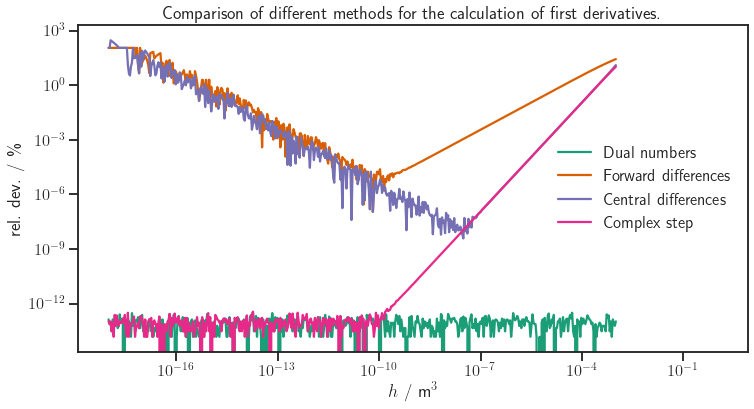

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.loglog(hs, d_dd, "-", label="Dual numbers")
plt.loglog(hs, d_fd, "-", label="Forward differences")
plt.loglog(hs, d_cd, "-", label="Central differences")
plt.loglog(hs, d_cs, "-", label="Complex step")
plt.hlines(0.0, hs[0]-1, hs[-1]+1, linestyle="--", alpha=0.5)
plt.xlabel(r"$h$ / m$^3$");
plt.ylabel("rel. dev. / \%");
plt.title("Comparison of different methods for the calculation of first derivatives.")
plt.legend(frameon=False);

### Second derivatives <a class="anchor" id="2nd_derivatives"></a>
[↑ back to Contents](#toc)

Complex step differentiation in its normal definition is only able to calculate first derivatives. For higher order derivatives, multicomplex numbers are required that are rarely implemented in existing frameworks. An implementation of multicomplex numbers specifically for the application of numeric derivatives is futile as there is no advantage over the usage of higher order dual numbers.

Comparing the error obtained using central differences to dual numbers, again shows that the optimal step size for central differences still results in an error several orders of magnitude above machine precision.

In [12]:
def rel_dev(x, ref):
    return np.abs(ref - x) / ref * 100

ideal_gas_dp_dv = -ideal_gas_pressure/v

hs = np.logspace(-10, -3, 500)
d_dd2 = []
d_cd2 = []
for h in hs:
    ref = pr.dp_dv(t, v, n)
    _, dd2 = dual_derivative(pr, t, v, n, h, "volume")
    _, cd2 = central_difference(pr, t, v, n, h, "volume")
    d_dd2.append(rel_dev(-dd2 + ideal_gas_dp_dv, ref))
    d_cd2.append(rel_dev(-cd2 + ideal_gas_dp_dv, ref))

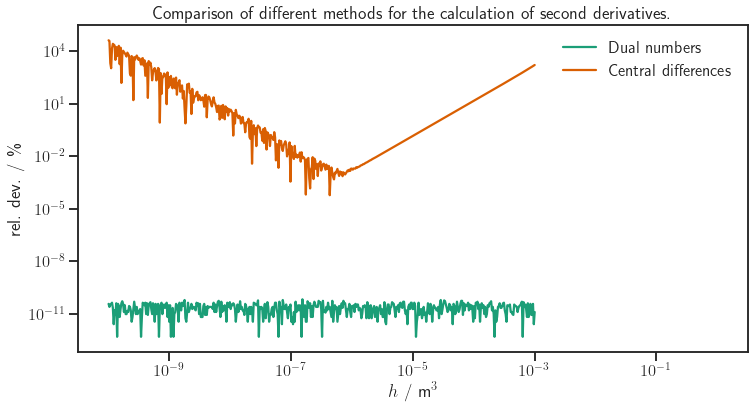

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.loglog(hs, d_dd2, "-", label="Dual numbers")
plt.loglog(hs, d_cd2, "-", label="Central differences")
plt.hlines(0.0, hs[0]-1, hs[-1]+1, linestyle="--", alpha=0.5)
plt.xlabel(r"$h$ / m$^3$");
plt.ylabel("rel. dev. / \%");
plt.title("Comparison of different methods for the calculation of second derivatives.")
plt.legend(frameon=False);

## Performance <a class="anchor" id="performance"></a>
[↑ back to Contents](#toc)

The examples below are meant to illustrate, that using dual numbers to calculate derivatives performes comparably to the less accurate forward or central differences.

The Python bindings are written with the focus on convenienve. As shown above, it is possible to call the same python function with different combinations of dual numbers or floats. This can only be achieved by dynamically checking the input types of every operator and calling the appropriate function in the underlying Rust library. If performance is critical to the application, the computation time can be decreased by up to several orders of magnitude by implementing and compiling the model in Rust.

#### First derivative: analytical, central difference, dual number

In [14]:
# thermodynamic state
t = 300.0
v = 3e-3
n = np.array([1.0])

# step width for volume
h = 1e-10
frac_2h = 1 / (2 * h)

In [15]:
%%timeit
_ = pr.pressure(t, v, n)

14.1 µs ± 525 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [16]:
%%timeit
_ = (pr.helmholtz_energy(t, v + h, n) - pr.helmholtz_energy(t, v - h, n)) * frac_2h

35 µs ± 1.64 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
%%timeit
_ = pr.helmholtz_energy(t, derive1(v), n).first_derivative

46.9 µs ± 2.09 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


#### Second derivative: analytical, central difference, dual number

In [18]:
h = 1e-7
frac_h2 = 1 / (h * h)

In [19]:
%%timeit
_ = pr.dp_dv(t, v, n)

14.7 µs ± 199 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [20]:
%%timeit
_ = (pr.helmholtz_energy(t, v + h, n) - 2*pr.helmholtz_energy(t, v, n) + pr.helmholtz_energy(t, v - h, n)) * frac_h2

51.8 µs ± 1.55 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [21]:
%%timeit
_ = pr.helmholtz_energy(t, derive2(v), n).second_derivative

45.7 µs ± 3.06 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


#### Helmholtz energy and derivatives

If an algorithm can be written in terms of the helmholtz and its derivatives (for example within a density iteration routine where a Newton scheme can be used where the gradient and second derivatives w.r.t volume are needed), generalized dual numbers have no disadvantages when compared to *the analytical implementation*. 

In [22]:
%%timeit
_ = pr.helmholtz_energy(t, derive2(v), n) # computes helmholtz energy (.value), first and second derivative w.r.t volume

44.4 µs ± 1.19 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [23]:
%%timeit
_ = pr.helmholtz_energy(t, v, n)
_ = pr.pressure(t, v, n)
_ = pr.dp_dv(t, v, n)

45 µs ± 987 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
